In [1]:
from deeplab3.dataloaders import make_data_loader
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math

import model_utils

Visualize Darkening Effect
----

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/coco_rgbd.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/coco/'])

In [3]:
dataloaders = make_data_loader(cfg)

loading annotations into memory...
Done (t=15.55s)
creating index...
index created!
Using RGB-D input
loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
Using RGB-D input


Text(0.5, 1.0, 'Original')

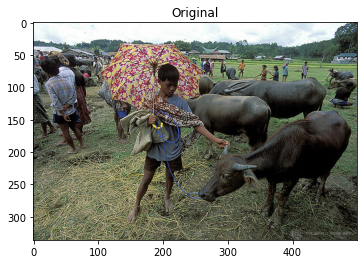

In [6]:
dataset = dataloaders[0].dataset
img_path, depth_path, label_path = dataset.coco_paths(2)
sample = dataset.loader.get_sample(img_path, depth_path, label_path)
image = sample['image']

plt.figure()
plt.imshow(image)
plt.title("Original")

### Different Darkening Degrees

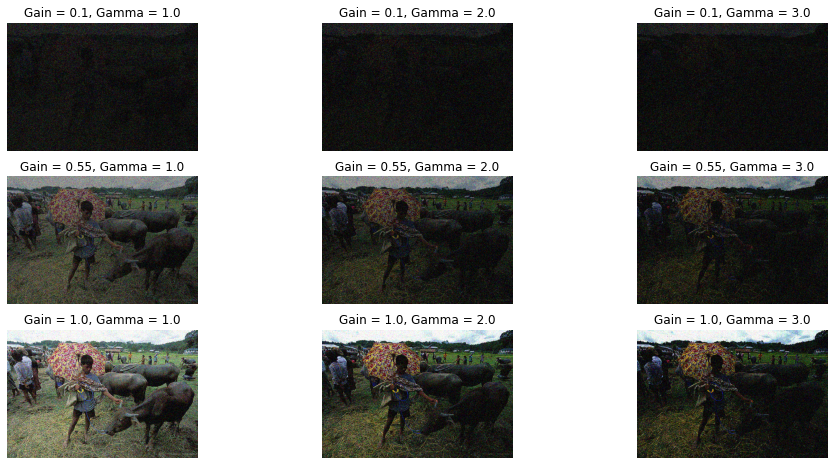

In [9]:
gain = np.linspace(0.1, 1, 3)
gamma = np.linspace(1,3, 3)

plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        
        index += 1

### RE-Brightened to visualize noise

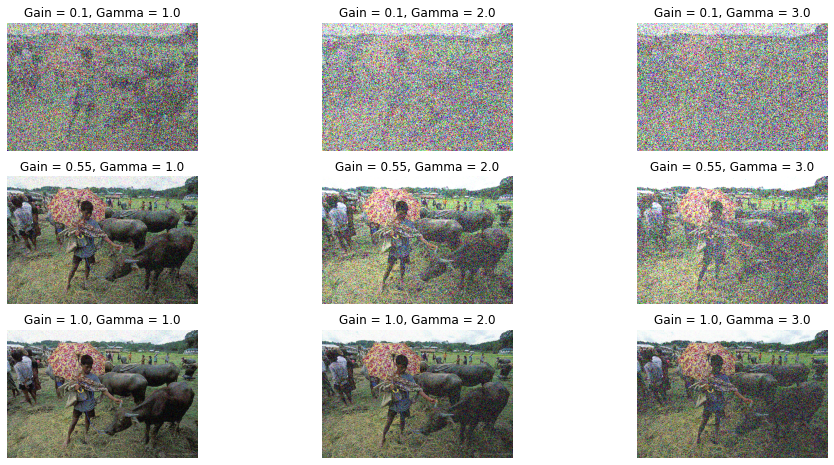

In [11]:
plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain), len(gamma), index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1

## Network Performance

In [ ]:
model_configs = model_utils.get_all_models("../run/")
len(model_configs)

In [ ]:
low_light_models = []

for cfg_filepath in model_configs:
    try:
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        if cfg.DATASET.DARKEN.DARKEN:
            low_light_models.append(cfg_filepath)

print(low_light_models)

In [ ]:
failed = []
model_output = {}

for cfg_filepath in low_light_models:
    try:
        cfg = model_utils.match_cfg_versions(cfg_filepath)
        cfg.merge_from_list(['CHECKPOINT.DIRECTORY', os.path.dirname(cfg_filepath),
                             'TEST.MAX_ITER', 1000,
                             'MODEL.PRETRAINED', "",
                             'SYSTEM.GPU_IDS', [0]]) #Since we're using saved models, pretrained weights will be overwritten anyway.

        for i in gain:
            for j in gamma:
                cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                                    'DATASET.DARKEN.GAIN', float(i),
                                    'DATASET.DARKEN.GAMMA', float(j)])
        
                model_filepath = os.path.join(cfg.CHECKPOINT.DIRECTORY, cfg.CHECKPOINT.MODEL)
                checkpoint = torch.load(model_filepath, map_location=torch.device('cpu'))

                model_output[i][j][cfg_filepath] = {'dataset': cfg.DATASET.NAME,
                                                 'model': cfg.MODEL.NAME,
                                                 'image_type': cfg.DATASET.MODE,
                                                 'epoch': checkpoint['epoch']}

                metrics = model_utils.test_model(cfg)
                model_output[i][j][cfg_filepath].update(metrics)
        
    except Exception as e:
        print(e)
        print(cfg_filepath)
        failed.append(cfg_filepath)
        

In [ ]:
print(failed)

In [14]:
import pickle
import datetime

filename = 'darken_test_{}.pkl'.format(datetime.datetime.now().isoformat(timespec='auto'))
print(filename)

with open(filename, 'ab') as fp:
    pickle.dump(model_output, fp) 

darken_test_2020-10-13T09:18:49.697620.pkl


In [ ]:
plt.figure(figsize=(16, 8))

index = 1
for i in gain:
    for j in gamma:
        sample['image'] = image.copy()
        
        cfg = get_cfg_defaults()
        cfg.merge_from_list(['DATASET.DARKEN.DARKEN', True,
                            'DATASET.DARKEN.GAIN', float(i),
                            'DATASET.DARKEN.GAMMA', float(j)])
        f = tr.Darken(cfg)
        processed_sample = f(sample)
        
        f = tr.UnDarken(cfg)
        processed_sample = f(processed_sample)
        
        plt.subplot(len(gain)*2, len(gamma)*2, index)
        plt.imshow(processed_sample['image'])
        plt.title("Gain = {}, Gamma = {}".format(i, j))
        plt.axis('off')
        index += 1
        
        metric = [value['mIOU'] for key, value in model_output[i][j].items()]
        name = [key for key,value in model_output[i][j].items()]
        ax1 = plt.subplot(len(gain)*2, len(gamma)*2, index)
        ax1.barh(metric)
        ax1.set_yticklabels(name)